Import data for train/test

In [1]:
import numpy as np
x_train = np.load('processed_data/first_experiment/x_train.npy')
x_test = np.load('processed_data/first_experiment/x_test.npy')
y_train = np.load('processed_data/first_experiment/y_train.npy')
y_test = np.load('processed_data/first_experiment/y_test.npy')

Define a model for SER

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, LSTM, TimeDistributed, InputLayer

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [9]:
input_shape = (128, 104, 1)
num_labels = 7
model = Sequential([
    InputLayer(input_shape=input_shape),
    TimeDistributed(Conv1D(64, kernel_size=(3), activation='relu', strides=(1))),
    TimeDistributed(MaxPooling1D(pool_size=(2), strides=(2))),
    TimeDistributed(Conv1D(64, kernel_size=(3), activation='relu', strides=(1))),
    TimeDistributed(MaxPooling1D(pool_size=(4), strides=(4))),
    TimeDistributed(Conv1D(128, kernel_size=(3), activation='relu', strides=(1))),
    TimeDistributed(MaxPooling1D(pool_size=(4), strides=(4))),
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=True),
    Flatten(),
    Dense(num_labels, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 128, 102, 64)      256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 51, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 49, 64)       12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 12, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 128, 10, 128)      24704     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 128, 2, 128)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 128, 256)          0

In [18]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
def test_step(model, images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [20]:
epochs = 2

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(model, images, labels)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels)

    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 1.88, Accuracy: 24.56, Test Loss: 1.76, Test Accuracy: 27.43
Epoch 2, Loss: 1.78, Accuracy: 29.76, Test Loss: 1.64, Test Accuracy: 33.63


In [9]:
model.save('trained_models/firstCNN_LSTM3')

INFO:tensorflow:Assets written to: trained_models/firstCNN_LSTM3\assets


INFO:tensorflow:Assets written to: trained_models/firstCNN_LSTM3\assets


In [15]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [21]:
from art.estimators.classification import TensorFlowV2Classifier


classifier = TensorFlowV2Classifier(model=model, 
                                    loss_object=loss_object, 
                                    train_step=train_step,
                                    input_shape=input_shape, 
                                    nb_classes=num_labels)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

In [22]:
classifier.fit(x=x_train, y=y_train, batch_size=32, nb_epochs=50)

In [23]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 0.0%


C:\Users\Nicolas Facchinetti\AppData\Local\Temp\ipykernel_17260\2216314400.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(predictions == y_test) / len(y_test)


In [21]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

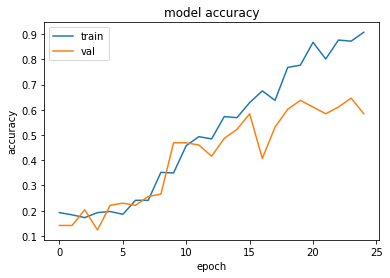

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

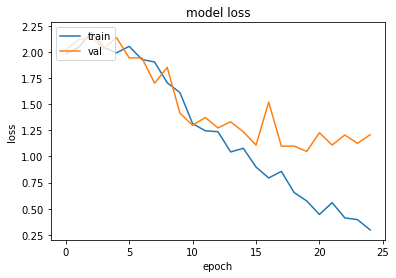

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

Accuracy on original test data: 63.72%


Save the model for future computations

In [11]:
model.save('trained_models/firstCNN_LSTM')

INFO:tensorflow:Assets written to: trained_models/firstCNN_LSTM\assets
